# Randomized Search

- Why is it better?
- How does it find the maxima for a metric?


No complex mathematics behind how Ranomized search find the global maxima for accuracies score. So how does it find out the global maxima values can be found out using simple probability calculations.

Calculation is based on the approximation that any distribution which has a finite maxima: __the maximum of 60 random observations lie within the top 5% of the true maxima with 95% probability__. 

Lets say we have 100 values of accuracy scores: lets assume we know for sure that the maximum score we have is 96% or 0.96 and so there will be other accuracy score closer to this values say 0.95, 0.94, 0.942, 0.93, 0.938, etc.  We will define something called the __5% interval around the maximum__. 

Now lets sample some points from the 100 points and we have to check whether the sample points lie in the 5% interval around the maximum.

__If I take one random accuracy then the probability of that random point lying in the 5% interval is 0.05.__ 

$$ P = \frac{5}{100}  = 0.05$$ 


So we want our samplr to lie in top 5% value then the probability that the random accuracy point will liwe there is 0.05. Similarly if we draw n points randomly and independently then the probability of the n points missing the 5% interval is:

$$(1 - 0.05)^n$$

If we want our global maxima to be part of this sampling that is done then 

$$ 1 - (1 - 0.05)^n $$

is probability of selecting 1 out of the draw of  samples.

So Probability of getting the global maxima must be:

$$ (1 - (1 -  0.05)^n) > 0.95 $$

$$  (0.95)^n > 0.05 $$

$$ n*log(0.95) > log10(0.05) $$

$$ n > \frac{log(0.05)}{log(0.95)} $$

$$ n > 59 $$

So this implies if we select 60 accuracies from a accuracy distribution of 100 samples randomly then there is 95% chance that we will end up at the top 5% interval of maximas which are present.



So if we have hyperparameter combinations given to us that are greater than 60 then we can use RandomSearch to converge at the top 5% interval of accuracy score maxima.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore") 

from sklearn import metrics, preprocessing, tree 
from sklearn.metrics import f1_score, make_scorer 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.model_selection import train_test_split 
import time

In [2]:
# Used to measure the time between 2 function calls
# will be used to determine difference in time taken between gridsearchCV and randomsearchCV
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

### Classification problem

In [3]:
file_loc = 'loan_prediction.csv'
df = pd.read_csv(file_loc)
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
0,5849,0.0,0.0,360.0,1.0,1
1,4583,1508.0,128.0,360.0,1.0,0
2,3000,0.0,66.0,360.0,1.0,1
3,2583,2358.0,120.0,360.0,1.0,1
4,6000,0.0,141.0,360.0,1.0,1


In [4]:
df.shape

(614, 6)

In [5]:
from sklearn.tree import DecisionTreeClassifier as dt
clf = dt()

In [6]:
clf # default parameters
X = df.iloc[:,0:len(df.columns)-1].values
Y = df.iloc[:,-1].values
X.shape

(614, 5)

In [7]:
Y.shape

(614,)

In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
X_train.shape

(460, 5)

In [9]:
X_test.shape

(154, 5)

Applying k-fold cross-validation

In [10]:
scores = cross_val_score(clf, X_train, Y_train, cv=5, scoring='f1_macro') # 5 folds
scores.mean() # score is less

0.6220550898283571

In [11]:
# Fit the model
clf.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [12]:
# Make predictions
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
clf

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [13]:
train_cols = df.columns[0:len(df.columns)-1]
target_cols = df.columns[-1]
print('The Training F1 Score is', f1_score(train_predictions, Y_train))
print('The Testing F1 Score is', f1_score(test_predictions, Y_test))

The Training F1 Score is 1.0
The Testing F1 Score is 0.7557603686635945


In [14]:
parameters = {'max_depth':[1,2,3,4,5], 'min_samples_leaf':[1,2,3,4,5], 'min_samples_split':[2,3,4,5],
              'criterion' : ['gini','entropy']}
scorer = make_scorer(f1_score)

In [16]:
@timeit   # decorator to find the time that the function will take to execute
def generate_clf_from_search(grid_or_random, clf, parameters, scorer, X, y):
    if grid_or_random == "Grid":
        search_obj = GridSearchCV(clf, parameters, scoring=scorer)
    elif grid_or_random == "Random":
        search_obj = RandomizedSearchCV(clf, parameters, scoring=scorer)
    fit_obj = search_obj.fit(X, y)
    best_clf = fit_obj.best_estimator_
    return best_clf, search_obj, fit_obj

In [17]:
best_clf_grid, search, fit = generate_clf_from_search("Grid", clf, parameters, scorer, X_train, Y_train)

'generate_clf_from_search'  2753.54 ms


In [18]:
fit.cv_results_['params'][0]

{'criterion': 'gini',
 'max_depth': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [19]:
fit.cv_results_['mean_test_score'][0]

0.8352478344185247

Now lets look at what values are there for different levels of hyperparameters.  We had a total of 200 decision trees and all corresponding decision trees have these corresponding accuracy_score.

In [20]:
fit.cv_results_['mean_test_score']

array([0.83524783, 0.83524783, 0.83524783, 0.83524783, 0.83524783,
       0.83524783, 0.83524783, 0.83524783, 0.83524783, 0.83524783,
       0.83524783, 0.83524783, 0.83524783, 0.83524783, 0.83524783,
       0.83524783, 0.83524783, 0.83524783, 0.83524783, 0.83524783,
       0.82968609, 0.82968609, 0.82968609, 0.82968609, 0.82968609,
       0.82968609, 0.82968609, 0.82968609, 0.82842572, 0.82842572,
       0.82968609, 0.82968609, 0.82842572, 0.82968609, 0.82842572,
       0.82968609, 0.83355059, 0.83355059, 0.83355059, 0.83355059,
       0.83020689, 0.83020689, 0.83020689, 0.83020689, 0.82842572,
       0.82842572, 0.82842572, 0.82842572, 0.82716536, 0.82842572,
       0.82716536, 0.82716536, 0.82842572, 0.82842572, 0.82842572,
       0.82842572, 0.83387705, 0.83387705, 0.83387705, 0.83387705,
       0.81104158, 0.81104158, 0.81104158, 0.81104158, 0.81163333,
       0.81163333, 0.81289021, 0.81163333, 0.80859512, 0.80859512,
       0.80732677, 0.80732677, 0.80732677, 0.80732677, 0.80732

In [21]:
len(fit.cv_results_['mean_test_score'])

200

So observe there are 200 such decision trees obtained using the hyperparameters. Saving all these 200 accuracy values to a numpy array.

In [22]:
out_f1_values = fit.cv_results_['mean_test_score']

In [23]:
out_f1_values.sort()

In [24]:
out_f1_values

array([0.79630878, 0.79630878, 0.79630878, 0.79630878, 0.79644583,
       0.79644583, 0.796708  , 0.796708  , 0.79717639, 0.79743699,
       0.79770552, 0.79801213, 0.7996587 , 0.7996587 , 0.80004968,
       0.80004968, 0.80084528, 0.80090649, 0.80091755, 0.80091755,
       0.80137842, 0.80206298, 0.80206298, 0.80206298, 0.80490575,
       0.80490575, 0.8053591 , 0.8053591 , 0.80552452, 0.80552452,
       0.80552452, 0.80552452, 0.80732677, 0.80732677, 0.80732677,
       0.80732677, 0.80732677, 0.80732677, 0.80813234, 0.80813234,
       0.80813234, 0.80813234, 0.80813234, 0.80813234, 0.80813234,
       0.80813234, 0.80859512, 0.80859512, 0.8092575 , 0.8092575 ,
       0.80971085, 0.80971085, 0.80973712, 0.80973712, 0.80973712,
       0.80973712, 0.81063226, 0.81063226, 0.81063226, 0.81063226,
       0.81104158, 0.81104158, 0.81104158, 0.81104158, 0.81147424,
       0.81163333, 0.81163333, 0.81163333, 0.81274908, 0.81274908,
       0.81274908, 0.81285797, 0.81285797, 0.81289021, 0.81347

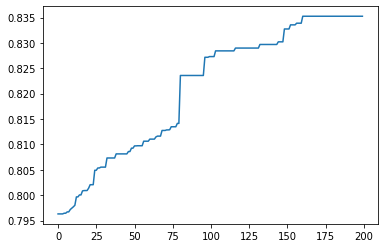

In [25]:
plt.plot(out_f1_values)

Plotted the values using matplotlib. So as discuused we want our samples to lie in the 5% intervals of the maximas.

To simulate the same behaviour we use a function called [np.random.choice()](https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.random.choice.html). We want only 61 values as from above we want only 60 independant trials or samples generated from our data.

In [27]:
r_values = np.random.choice(out_f1_values, 61, replace = False)

In [28]:
r_values  # the list of 61 values we have

array([0.83020689, 0.83524783, 0.796708  , 0.82357922, 0.82842572,
       0.83524783, 0.81413729, 0.80206298, 0.83524783, 0.82842572,
       0.7996587 , 0.82968609, 0.83355059, 0.82968609, 0.83524783,
       0.80973712, 0.80859512, 0.80813234, 0.83273952, 0.80490575,
       0.82842572, 0.82357922, 0.82842572, 0.8289797 , 0.81104158,
       0.82357922, 0.82842572, 0.80732677, 0.83524783, 0.82730059,
       0.80091755, 0.80971085, 0.81063226, 0.79801213, 0.80973712,
       0.8289797 , 0.82968609, 0.80552452, 0.83020689, 0.83524783,
       0.80004968, 0.80206298, 0.79630878, 0.82842572, 0.83524783,
       0.83524783, 0.8053591 , 0.83524783, 0.80813234, 0.83524783,
       0.83355059, 0.80552452, 0.82842572, 0.83387705, 0.81163333,
       0.82357922, 0.83524783, 0.80090649, 0.83273952, 0.83524783,
       0.82842572])

In [29]:
r_values.max()

0.8352478344185247

Now we want to ensure that we have the global maxima or the 5% maxima that lie in this interval. So here I am just taking a values slightly lesser than the maximum value.

In [30]:
r_values[r_values > 0.83390239]

array([0.83524783, 0.83524783, 0.83524783, 0.83524783, 0.83524783,
       0.83524783, 0.83524783, 0.83524783, 0.83524783, 0.83524783,
       0.83524783, 0.83524783])

So we still have a good number of samples that are beyond the 5% interval that was there. This helps to infer if we have n number of combinations for your grid search to validate on then random search can come in handy by randomly sapling points or sampling combinations and it gives u an assurance that 61 or 65 combinations we can keep a limit based on the computaional power we have in hand so with set number of combinations we can reach the 5% interval of maxima with 95% probability.